In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

from docplex.mp.model import Model
# from NPG_CMDP import CMDP_NPG
# from ARNPG_CMDP import CMDP_ARNPG

"""Our code customizes the CMDP code from the paper:
Natural Policy Gradient Primal-Dual Method for Constrained Markov Decision Processes, Dongsheng Ding et al.
"""

"""Natural Policy Gradient Primal-Dual Method with Softmax Parametrization
"""
from MARL import MARL_agent, MO_MARL
# Random Seed
np.random.seed(10)


In [2]:
from MARL import MARL_agent
n = 2
a = 2
s = 5
gamma = 0.8

A = a**n

# Randomly generated probability transition matrix P((s,a) -> s') in [0,1]^{|S||A| x |S|}
raw_transition = np.random.uniform(0, 1, size=(s * A, s))
# raw_transition = np.ones((s * A, s))
prob_transition = raw_transition / raw_transition.sum(axis=1, keepdims=1)
# print(prob_transition)
# Random positive rewards

reward = np.random.uniform(0, 1, size=(s * A))

# potential = np.random.uniform(0, 1, size=(n,s,a))
# reward = np.zeros((s * A))
# for state in range(s):
#     for action in range(A):
#         temp = action
#         for agent in range(n):
#             local_action = temp%n
#             temp = int(temp/n)
#             reward+=potential[agent,state, local_action]

rewards = [reward]
# Random positive utilities
# utility = np.random.uniform(0, 1, size=(s * A))
# Utility constraint offset b
# Start state distribution
rho = np.ones(s) / s
# rewards = [reward]
temp = MARL_agent(rewards, s, a, rho, gamma, n, prob_transition)
temp.tau = 0
temp.step = 0.1
# temp.theta = np.random.uniform(0, 1, size=n* s* a)
temp.theta = np.zeros(shape=n* s* a)


100%|██████████| 2/2 [00:00<00:00, 249.94it/s]

iteration: 1
A_tildes [array([-0.17041413,  0.17041413,  0.15389465, -0.15389465, -0.11199464,
        0.11199464,  0.06270127, -0.06270127,  0.11141779, -0.11141779]), array([ 0.22220933, -0.22220933,  0.20752353, -0.20752353,  0.02476569,
       -0.02476569,  0.11810349, -0.11810349, -0.24175457,  0.24175457])]
theta [-0.08520706  0.08520706  0.07694733 -0.07694733 -0.05599732  0.05599732
  0.03135064 -0.03135064  0.05570889 -0.05570889  0.11110466 -0.11110466
  0.10376177 -0.10376177  0.01238284 -0.01238284  0.05905175 -0.05905175
 -0.12087729  0.12087729]
prob [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]
Average gap: 4.265322714950305
iteration: 2
A_tildes [array([-0.17041413,  0.17041413,  0.15389465, -0.15389465, -0.11199464,
        0.11199464,  0.06270127, -0.06270127,  0.11141779, -0.11141779]), array([ 0.22220933, -0.22220933,  0.20752353, -0.20752353,  0.02476569,
       -0.02476569,  0.11810349, -0.11810349, -0.24175457,  0.24175457])]


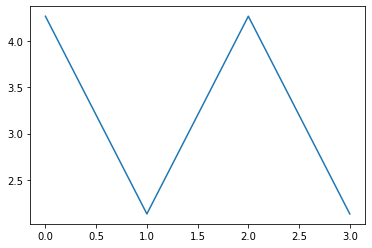

In [4]:
temp = MARL_agent(rewards, s, a, rho, gamma, n, prob_transition)
temp.tau = 0
temp.step = 0.1
# temp.theta = np.random.uniform(0, 1, size=n* s* a)
temp.theta = np.zeros(shape=n* s* a)

N = 2
for i in tqdm(range(N)):
    temp.theta = np.zeros(shape=n* s* a)

    temp.NPG_entropy_step(verbose = True)
#     temp.NPG_entropy_step(verbose = False)
    temp.theta = np.zeros(shape=n* s* a)

    temp.NPG_entropy_step_change(verbose = True)

# temp.NPG_entropy_step(verbose = True)
#     temp.NPG_entropy_step(verbose = False)
#     print("prob", temp.theta_to_policy())
plt.plot(temp.gap)
# print(temp.gap)
# plt.plot(temp.avg_gap)

<ipython-input-38-be148b8d5310>:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(n*5*np.log(2)-temp.gap))


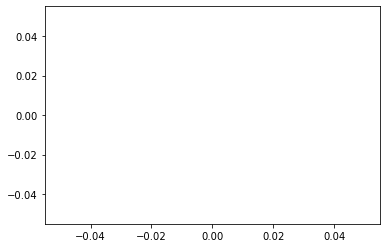

In [38]:
# plt.plot(np.log(n*5*np.log(2)-temp.gap))

In [21]:
# Q = np.array([ 0,         0,         0,         0,       6.85999004,  6.85999004, -2.65030868, -2.65030868])
# prob = np.array([0.60584483, 0.39415517, 0.55062551, 0.44937449, 0.5,        0.5, 0.27867775, 0.72132225])
# i = 1
# Q_tilde = np.zeros(s * a)
# for state in range(s):
#     for global_action in range(A):
#         multiplier = 1
#         temp = global_action
#         for agent in range(n):

#             local_action = temp%a
#             temp = int(temp/a)
#             if agent!=i:
#                 multiplier*= prob[agent*(s*a)+state*a+local_action]
#             else:
#                 agent_action = local_action
#         print("other prob", multiplier, "agent action", agent_action, "corresponding Q", Q[state*a+global_action])
#         Q_tilde[state*a+agent_action] += Q[state*A+global_action]*multiplier


#         # Q[i * self.A + j] = func[i * self.A + j] + self.gamma * np.matmul(self.prob_transition[i * self.A + j], V)
# print("out:", Q_tilde)
# # return Q_tilde

-0.17558321835816137


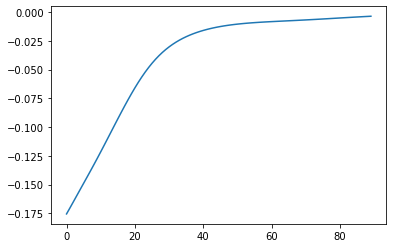

In [4]:
for i in range(0,len(temp.gap)-1):
    temp.gap[i] -= temp.gap[i+1]
plt.plot(temp.gap[0:90])
print(np.min(temp.gap[0:90]))

In [5]:
prob = temp.theta_to_policy()
Pi = temp.get_Pi(prob)
mat = np.identity(temp.s * temp.A) - temp.gamma * np.matmul(temp.prob_transition, Pi)
P_theta = np.matmul(Pi, temp.prob_transition) # |S|*|S|
d_pi = (1 - temp.gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(temp.s) - temp.gamma * P_theta))), temp.rho)

print(temp.theta)
print(prob)

[2.32789176 1.42730195 0.         0.17390555 0.35655456 0.38287269
 0.20226845 0.22354205]
[0.71107069 0.28892931 0.45663285 0.54336715 0.49342085 0.50657915
 0.4946818  0.5053182 ]


In [ ]:
N = 500
ax1 = plt.subplot(211)
# ax1.plot(t, np.sin(2*np.pi*t))

ax2 = plt.subplot(212, sharex=ax1)
# ax2.plot(t, np.sin(4*np.pi*t))

for j in range(5):
    temp = MO_MARL(rewards, s, a, rho, gamma, n, prob_transition)
    for i in tqdm(range(N)):
        temp.Centralized_NPG_step(verbose = False)
    ax1.plot(temp.gap)
    ax2.plot(temp.avg_gap)
    
plt.show()
    

 32%|███▏      | 158/500 [00:01<00:02, 140.39it/s]

In [14]:
agent_num = 5
Laplacian = np.zeros((agent_num, agent_num))

for i in range(agent_num):
    Laplacian[i,i] = -2
    Laplacian[i,(i+1)%agent_num] = 1
    Laplacian[i,(i-1)%agent_num] = 1
print(Laplacian)

W = np.zeros((agent_num, agent_num))
eta = 0.1
for i in range(agent_num):
    W[i,i] = 1-2*eta
    W[i,(i+1)%agent_num] = eta
    W[i,(i-1)%agent_num] = eta
print(W)



[[-2.  1.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 1.  0.  0.  1. -2.]]
[[0.8 0.1 0.  0.  0.1]
 [0.1 0.8 0.1 0.  0. ]
 [0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.1 0.8 0.1]
 [0.1 0.  0.  0.1 0.8]]


In [9]:
agent_list = []
for i in range(agent_num):
    agent_list.append(MO_MARL(rewards, s, a, rho, gamma, n, prob_transition))
# for k in range(5):
old_grad = np.zeros((agent_num, reward_num))
grad = np.zeros((agent_num, reward_num))
y = np.zeros((agent_num, reward_num))
all_theta = np.zeros((agent_num, n*s*a))
N = 1000
for k in tqdm(range(N)):
    
    for i in range(agent_num):
        grad[i] = agent_list[i].calculate_G(num=i,verbose = False)
        all_theta[i] = copy.deepcopy(agent_list[i].theta)

    y = W@y+grad-old_grad
#     y = W@grad
#     y = copy.deepcopy(grad)
#     y = y + eta*Laplacian@grad
    old_grad = copy.deepcopy(grad)
    all_theta = W@all_theta
        
    for i in range(agent_num):
        agent_list[i].theta=all_theta[i]
        agent_list[i].NPG_step_given_G(y[i], verbose = False)
        

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


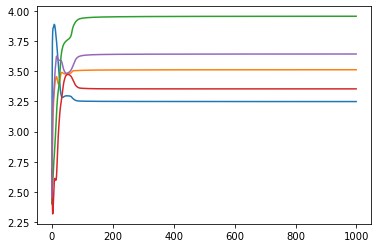

In [10]:
# plt.plot(agent_list[0].Q_record)
plt.plot(agent_list[0].V_record[0])
plt.plot(agent_list[0].V_record[1])
plt.plot(agent_list[0].V_record[2])
plt.plot(agent_list[0].V_record[3])
plt.plot(agent_list[0].V_record[4])

6.313887881586048
6.266685230417442
6.30454248226258
6.367220519322908
6.312252667057926


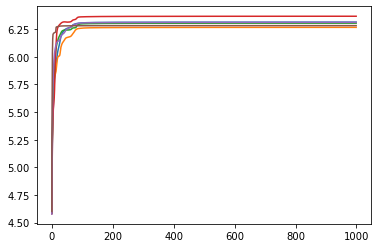

In [13]:
# plt.plot(agent_list[0].gap)

for i in range(agent_num):
    plt.plot(agent_list[i].gap)
    print(agent_list[i].gap[-1])
plt.plot(temp.gap)